importing everything needed()

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler
import string
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import savgol_filter
from joblib import dump

reading file

In [83]:
df = pd.read_csv(r"C:\Users\dimas\OneDrive\Studying Data\e_commerce_retail_data.csv",encoding='ansi')

taking a quick peek at the data

In [84]:
print(df.columns,df.dtypes,df.head())

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object') InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United 

changing dtypes of some columns unto more suitable

In [85]:
df['CustomerID'] = np.round(df['CustomerID']).astype('category')
df['InvoiceNo'] = df['InvoiceNo'].astype('category')
df['StockCode'] = df['StockCode'].astype('category')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [86]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

setting missing values for country column

In [87]:
df.loc[df['Country']=='Unspecified','Country'] = None
df['Country'] = df['Country'].astype('category')

checking if hours(may prove to be useful later)

<AxesSubplot:ylabel='Frequency'>

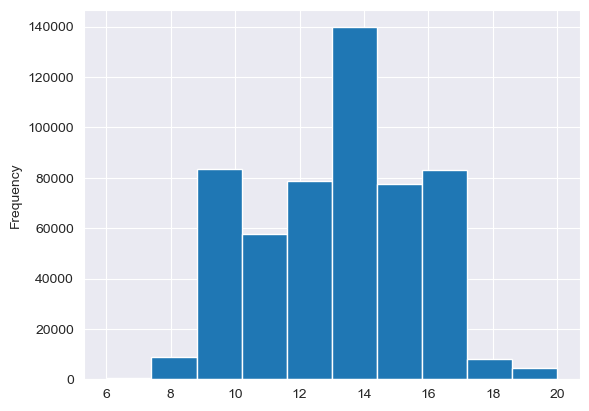

<AxesSubplot:ylabel='Frequency'>

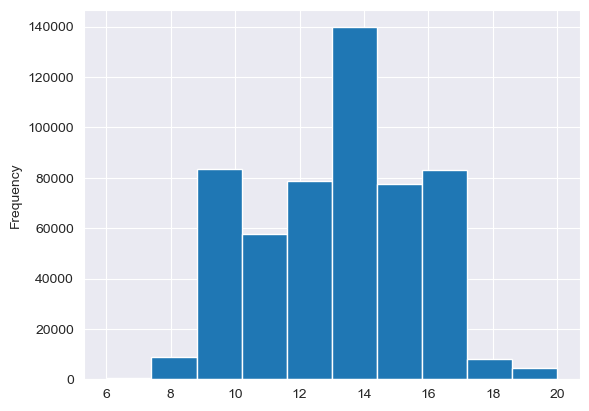

In [88]:
hours = df['InvoiceDate'].dt.hour
hours.plot.hist()

visualizing missingness

AxesSubplot(0.125,0.11;0.698618x0.77) AxesSubplot(0.125,0.11;0.62x0.77)


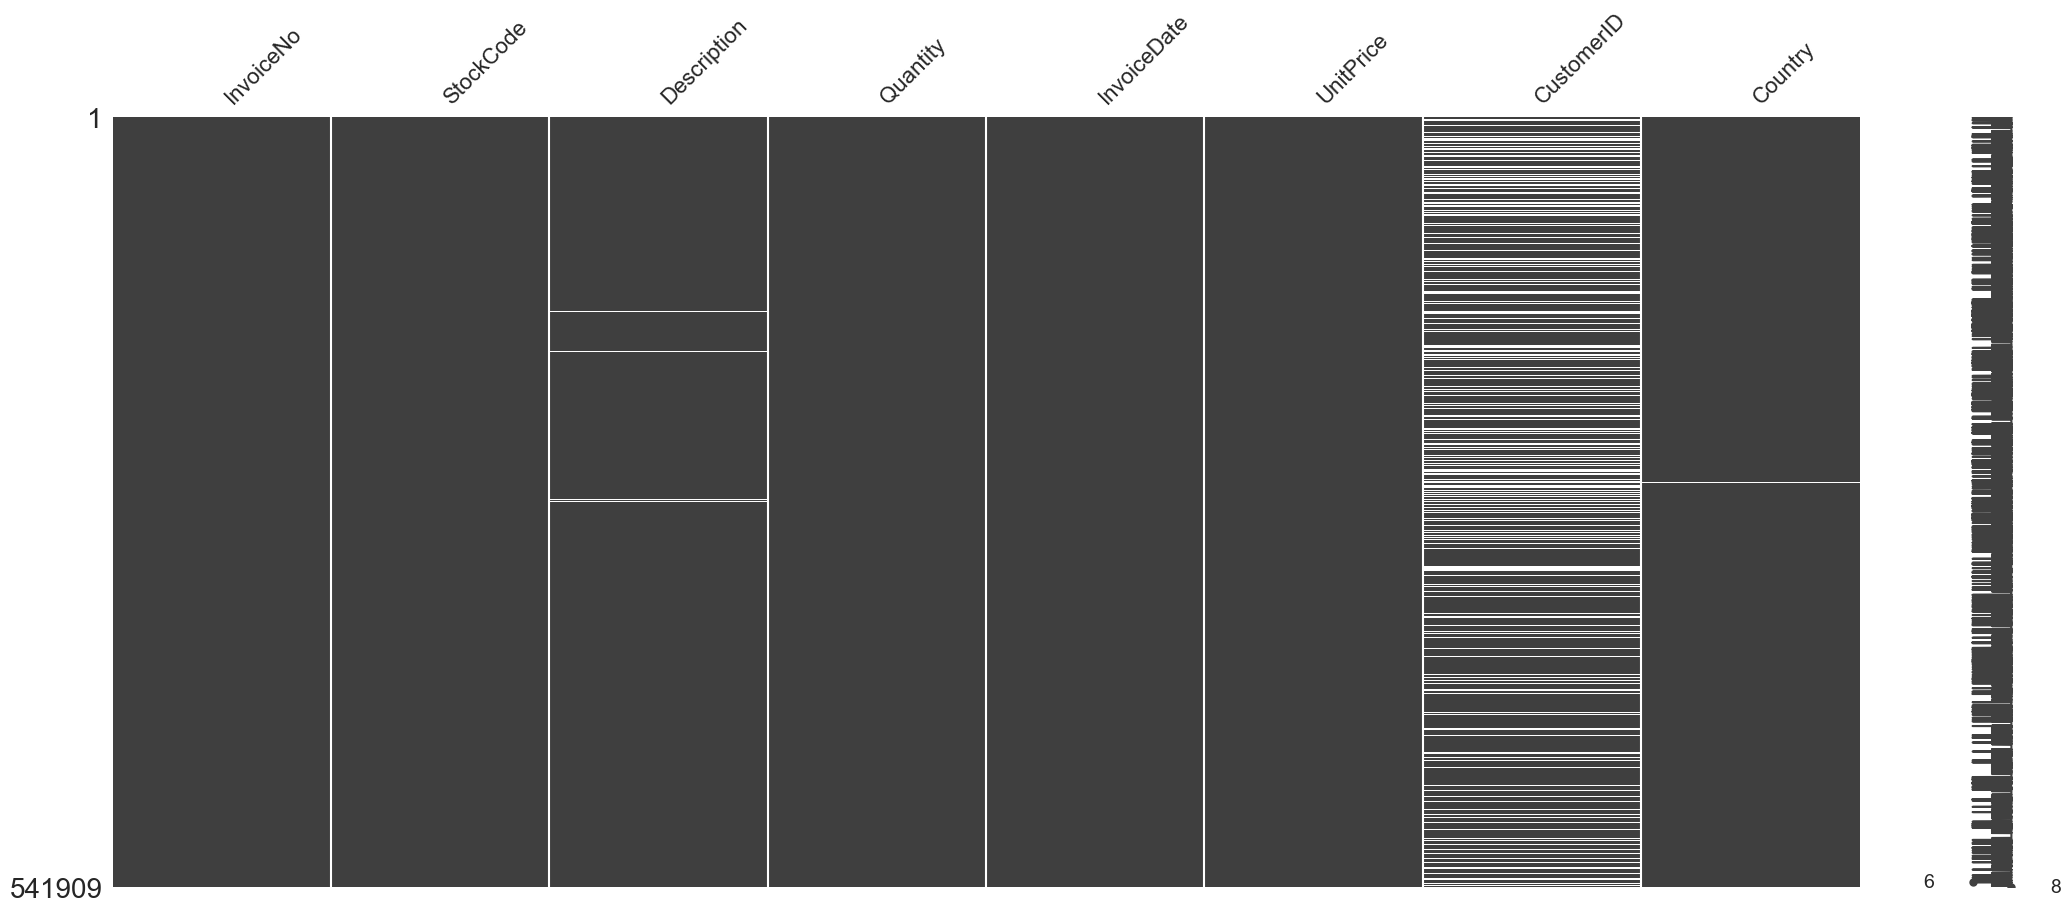

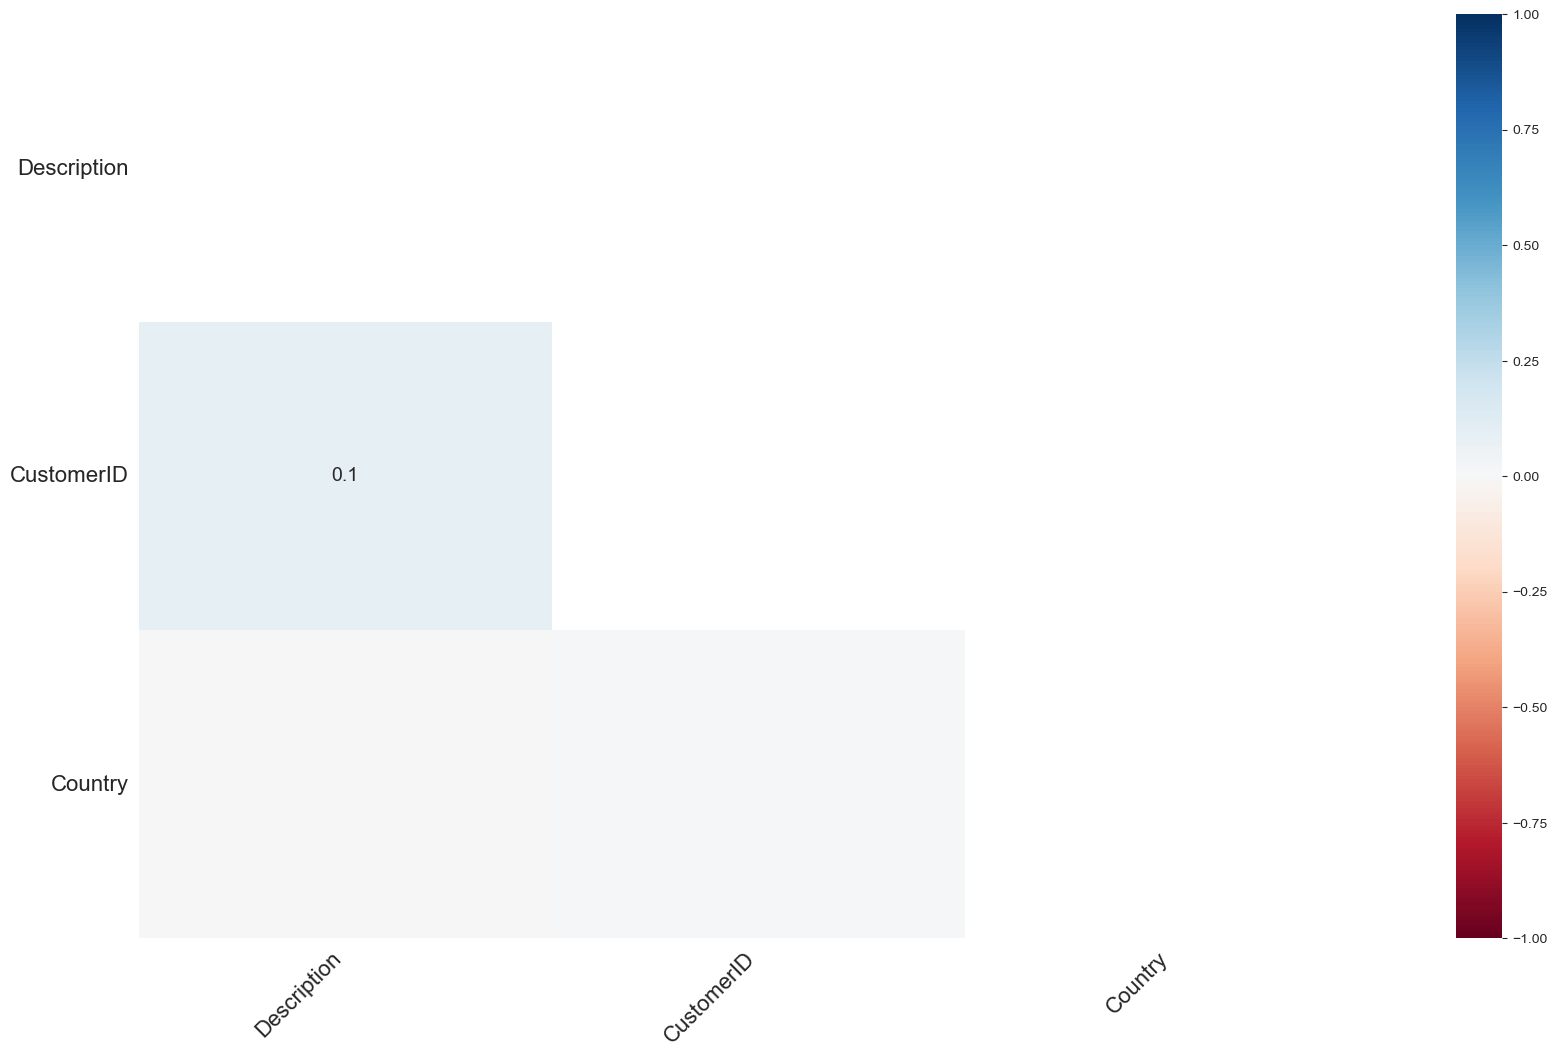

AxesSubplot(0.125,0.11;0.698618x0.77) AxesSubplot(0.125,0.11;0.62x0.77)


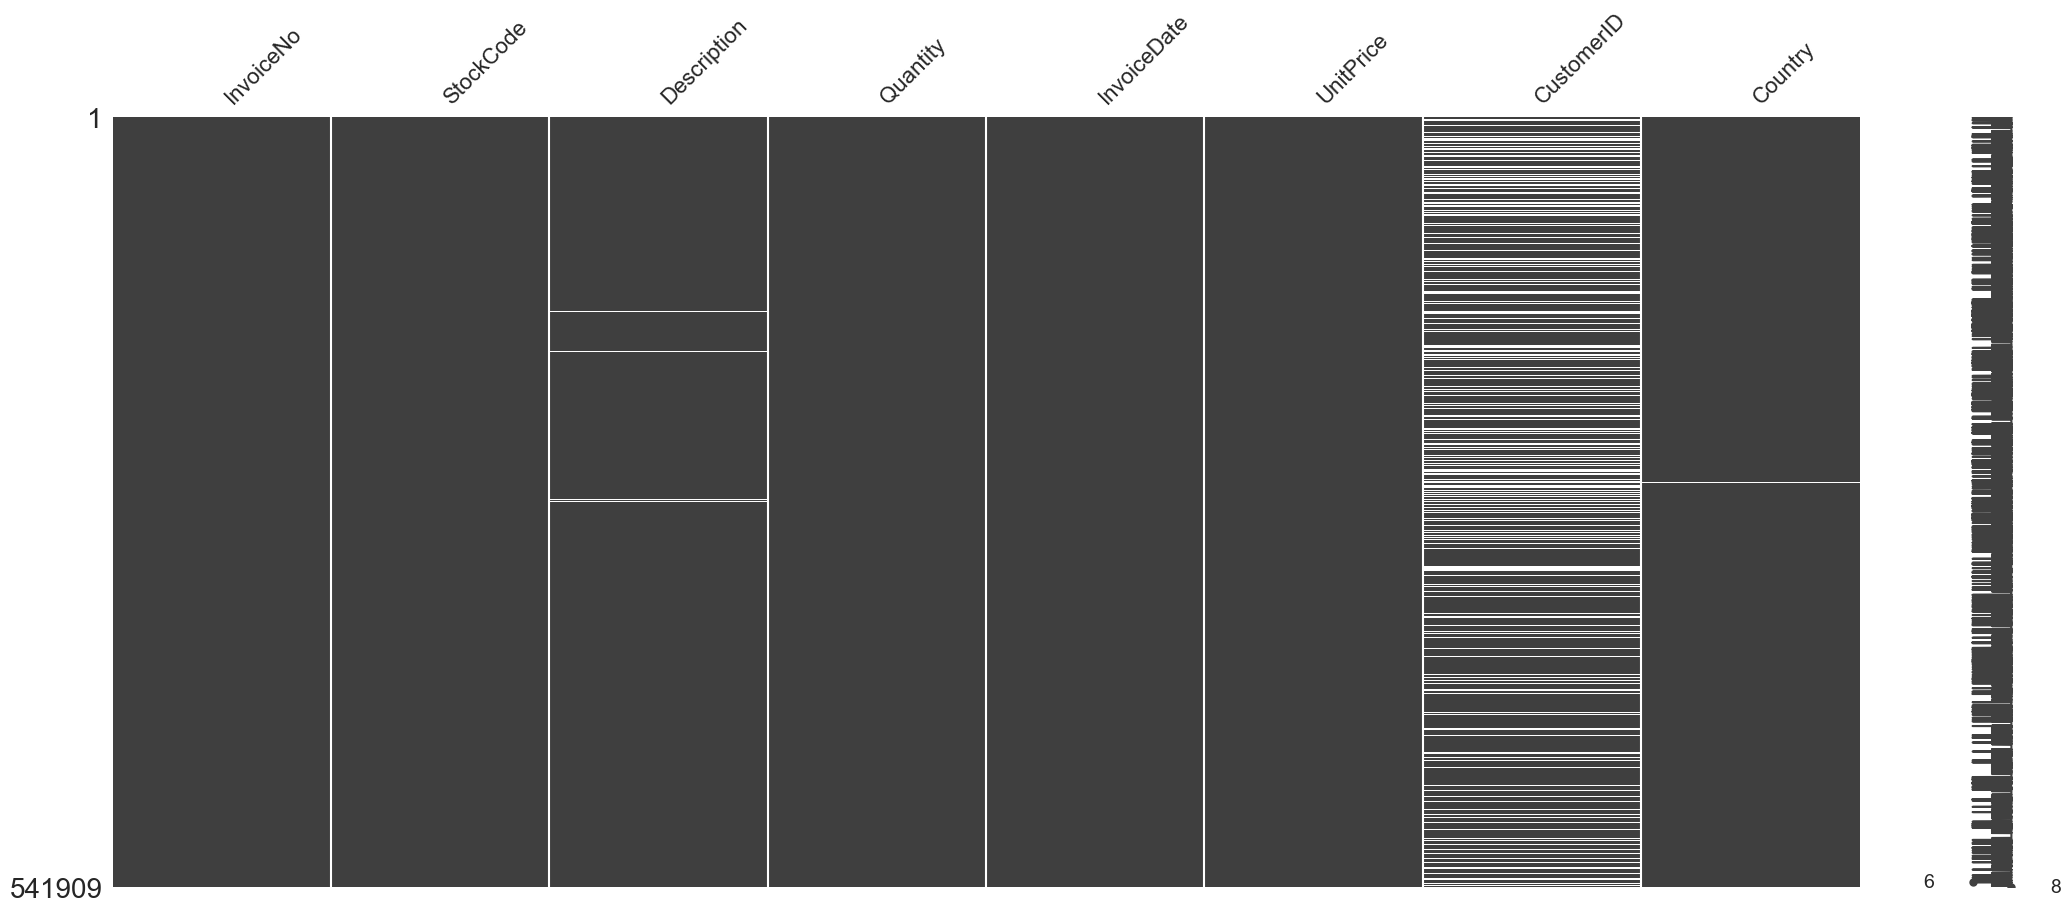

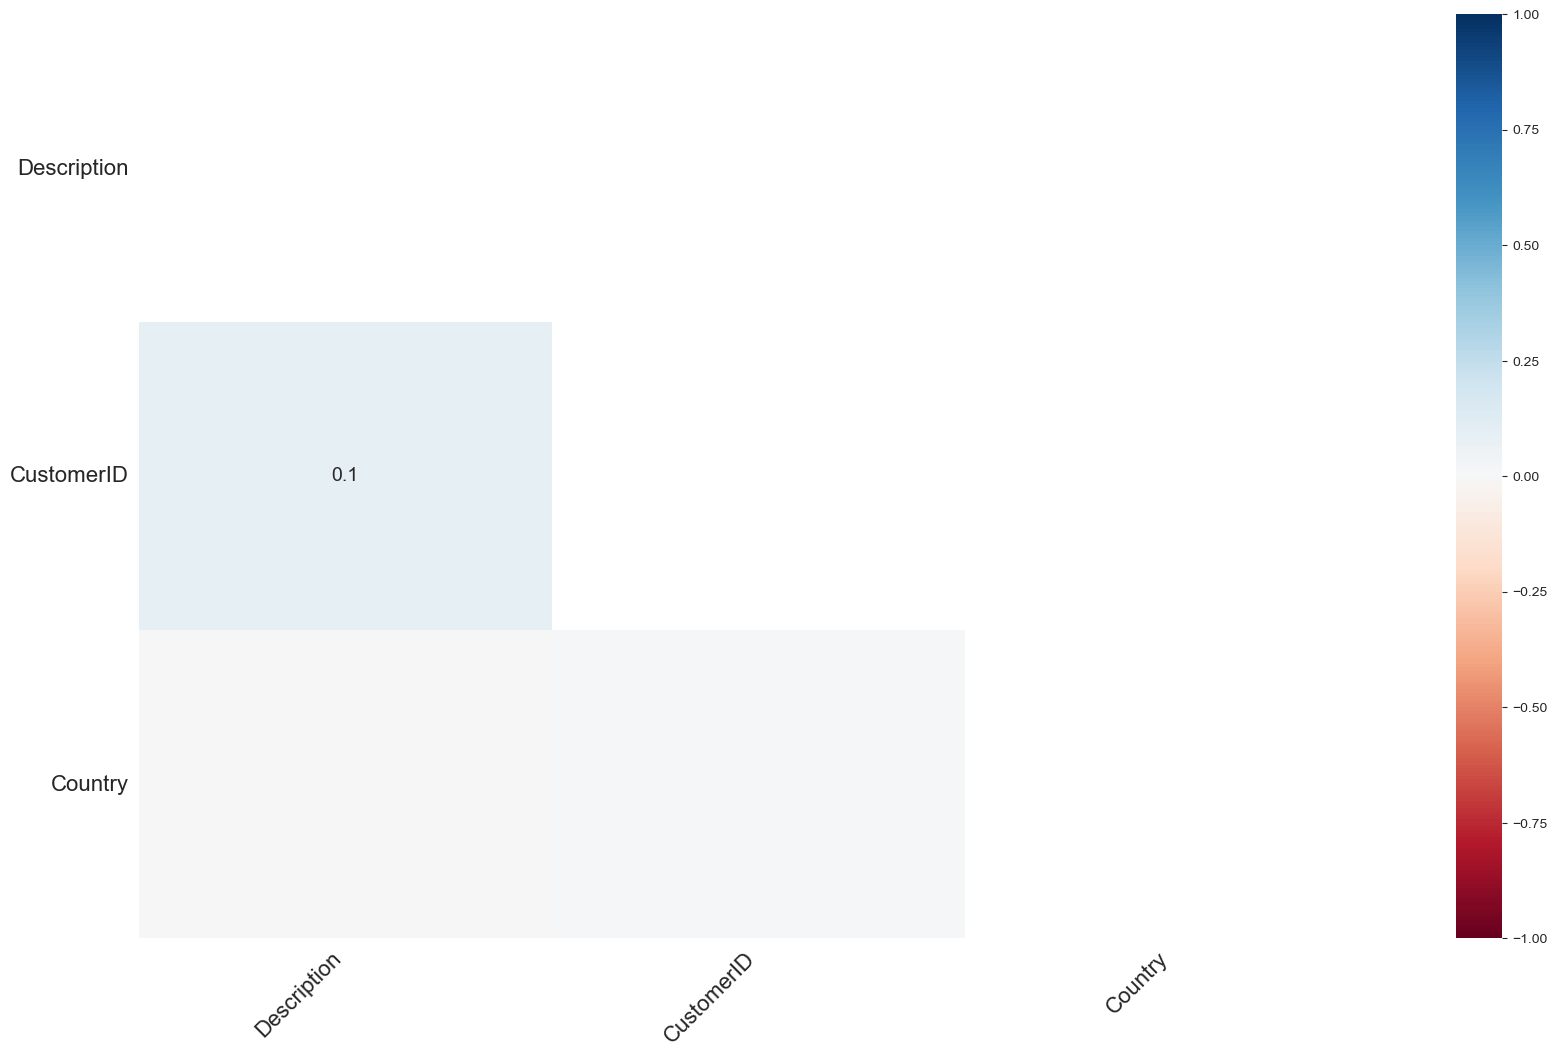

In [89]:
print(msno.matrix(df),msno.heatmap(df))

figuring out how many missing ids are there in percentage

In [90]:
percent_missing = df['CustomerID'].isnull().mean() * 100
print(f"Percentage of missing values in column 'column_name': {percent_missing:.2f}%")

Percentage of missing values in column 'column_name': 24.93%
Percentage of missing values in column 'column_name': 24.93%


In [91]:
total_missing = df.isna().sum().sum()
percentage_missing = (total_missing / df.size) * 100
print("Percentage of missing values in the dataset: {:.2f}%".format(percentage_missing))

Percentage of missing values in the dataset: 3.16%
Percentage of missing values in the dataset: 3.16%


During analysis of missingness distribution,I have decided to simply drop Na's because of 2 factors.
1)There is no possible way to impute customer identificators at the moment,so that it would not introduce bias into the goals of our analysis(I have tested it,and clusters tend to become a complete mess)
2)Missing values in other columns actually are distributed at random,and supposedly possible to impute,but due to their low number and my unfamiliarity with data it would not prove to be profitable

In [92]:
df = df.dropna()

creating a new column which tells if the transaction is cancelled(i have noticed that c in invoice number means that it is a cancel

In [93]:
df['order_canceled'] = df['InvoiceNo'].apply(lambda x:int('C' in x))
df['order_canceled']=df['order_canceled'].astype('bool')

In [94]:
df['order_canceled'].mean()

0.021901939323880616

0.021901939323880616

cross validating columns basing on them being a cancel(they can not have positive quantity,and must have a positive partner.Although some of them might have had a partner before the beginning of gathering data for that dataset,I dont have data for this.Also it is unlikely for date of canceled order to be smaller than date of it's partner

In [95]:
#copying dataframe so that i would avoid risks in process of checking it
df_initial = df.copy(deep=True)
df_cancel_analysis = df.copy(deep=True)
df_cancel_analysis['QuantityCanceled'] = 0
#creating arrays to entry untrustworthy data points
to_remove = [] ; doubtful = []
for index, col in  df_cancel_analysis.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity']   > 0)].copy()
    if df_test.shape[0] == 0:
        doubtful.append(index)
    elif df_test.shape[0] == 1:
        index_order = df_test.index[0]
        df_cancel_analysis.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        to_remove.append(index)
    elif df_test.shape[0] > 1:
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cancel_analysis.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            to_remove.append(index)
            break

In [96]:
print("to_remove: {}".format(len(to_remove)))
print("doubtful: {}".format(len(doubtful)))

to_remove: 7543
doubtful: 1229
to_remove: 7543
doubtful: 1229


there is not a critical amount of them,so i will just remove them

In [97]:
df_cancel_analysis.drop(to_remove, axis = 0, inplace = True)
df_cancel_analysis.drop(doubtful, axis = 0, inplace = True)

In [98]:
print("to_remove: {}".format(len(to_remove)))
print("doubtful: {}".format(len(doubtful)))

to_remove: 7543
doubtful: 1229
to_remove: 7543
doubtful: 1229


In [99]:
df_cancel_analysis.shape

(397813, 10)

(397813, 10)

In [100]:
df = df_cancel_analysis

taking a control look

In [101]:
print(df.shape,df.columns,df.dtypes,df.head())

(397813, 10) Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'order_canceled',
       'QuantityCanceled'],
      dtype='object') InvoiceNo                 category
StockCode                 category
Description                 object
Quantity                     int64
InvoiceDate         datetime64[ns]
UnitPrice                  float64
CustomerID                category
Country                   category
order_canceled                bool
QuantityCanceled             int64
dtype: object   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  

figuring out numerical outliers of orders

C:\Users\dimas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

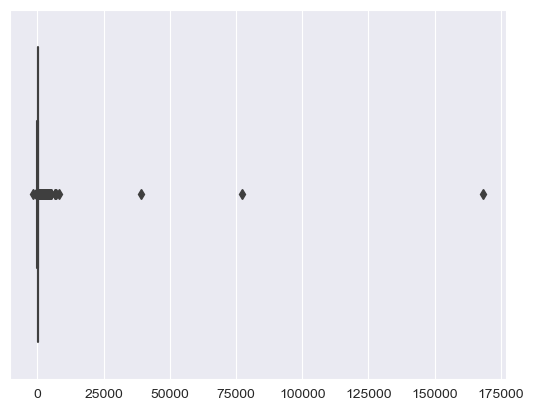

C:\Users\dimas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

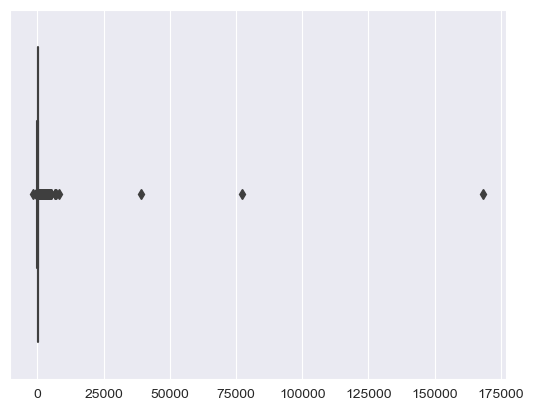

In [102]:
sns.boxplot(df['Quantity']*df['UnitPrice'])

that column was needed only for crosss-validating the data,so I drop it now

In [103]:
df = df.drop('QuantityCanceled',axis=1)

(397813, 9) InvoiceNo               category
StockCode               category
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID              category
Country                 category
order_canceled              bool
dtype: object AxesSubplot(0.125,0.11;0.698618x0.77)


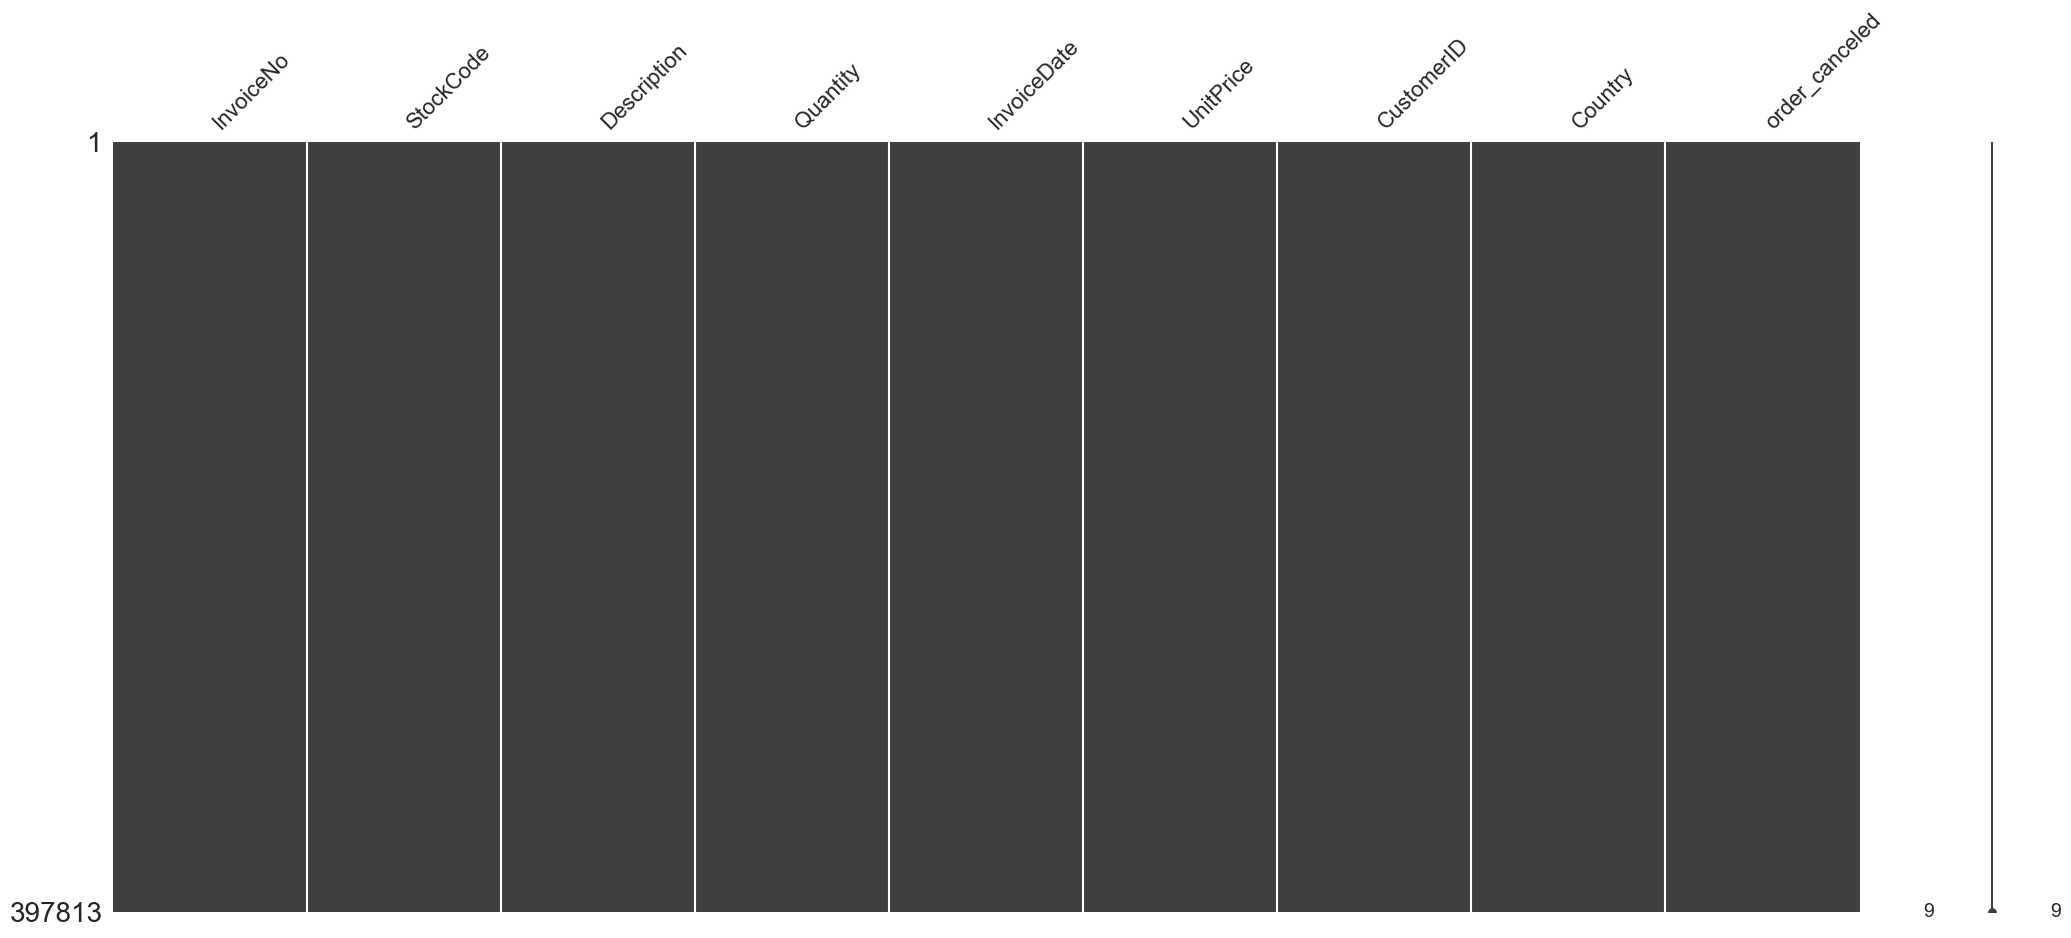

(397813, 9) InvoiceNo               category
StockCode               category
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID              category
Country                 category
order_canceled              bool
dtype: object AxesSubplot(0.125,0.11;0.698618x0.77)


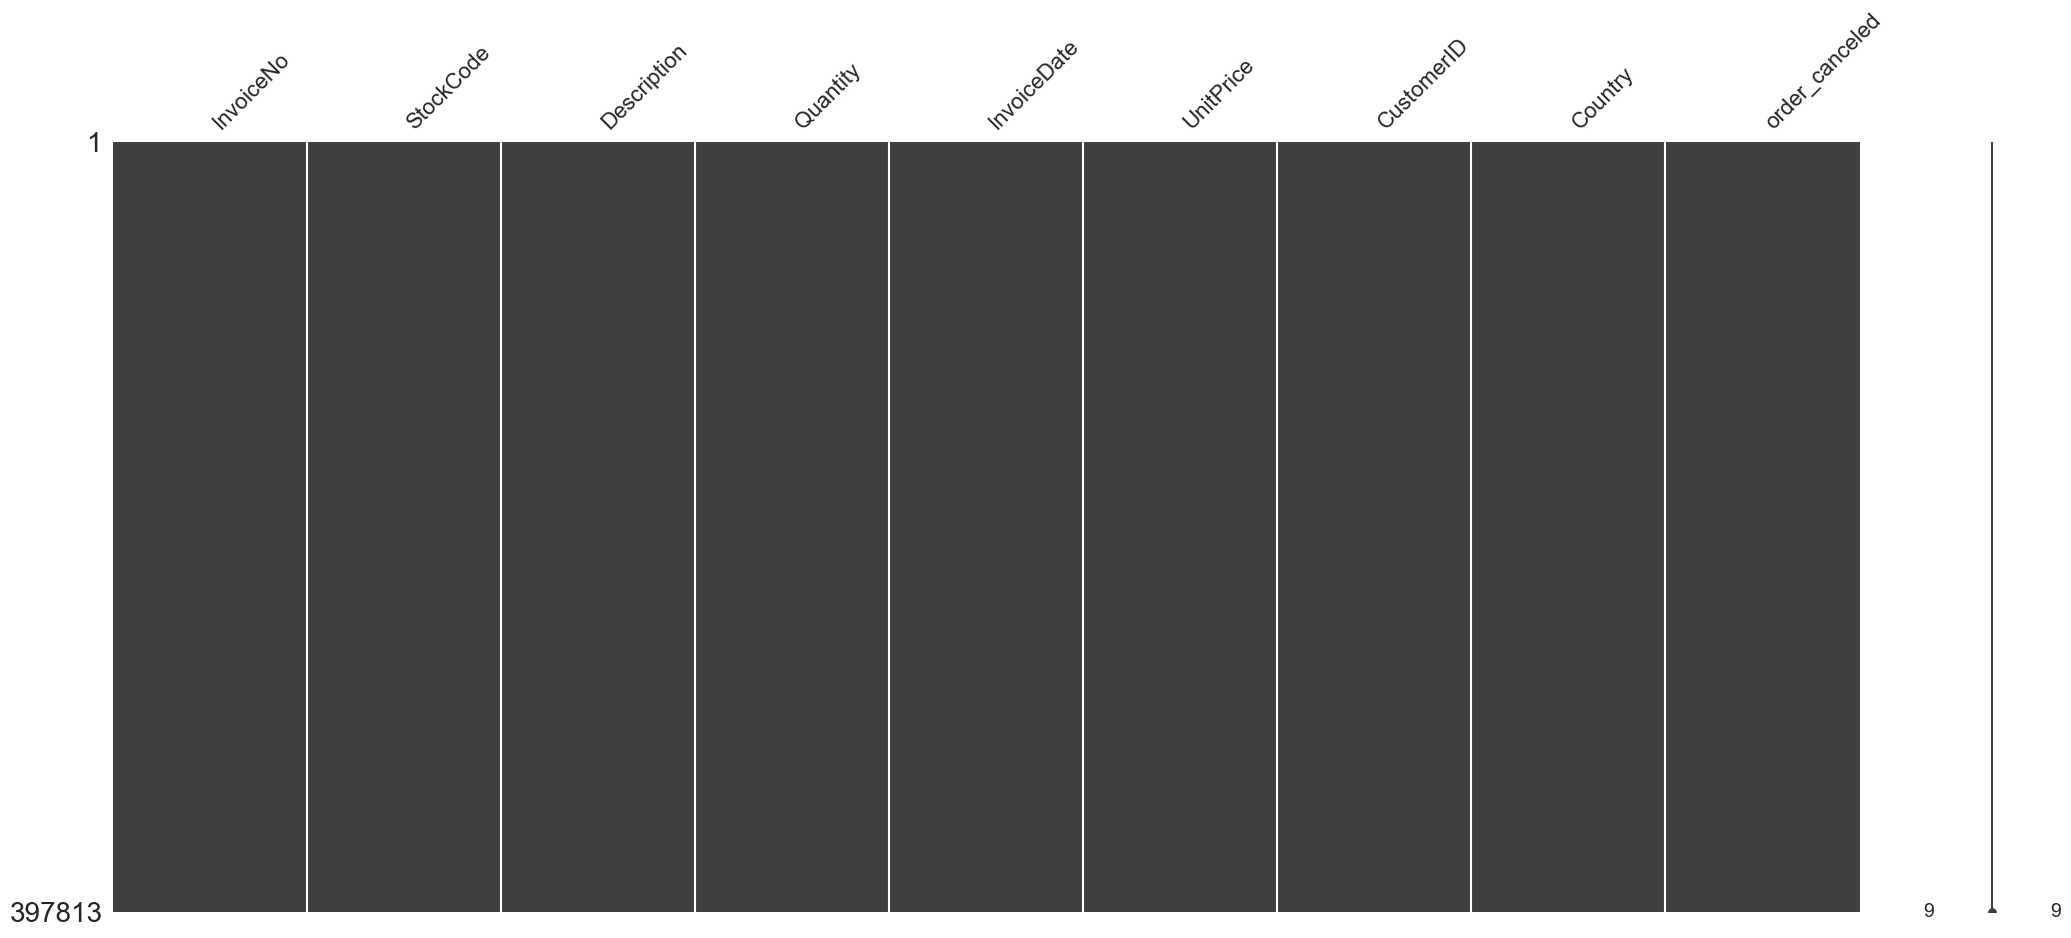

In [104]:
print(df.shape,df.dtypes,msno.matrix(df))

dropping negative,zero,and really close to zero prices(they may appear due to data entry mistake)

In [105]:
df = df[df['UnitPrice']>0.001]

In [106]:
df.shape

(397769, 9)

(397769, 9)

dropping rows where it quantity is negative,but it is not a cancellation

In [107]:
df =df[(df['Quantity']<=0)^(df['order_canceled']==False)]

In [108]:
df.shape

(397769, 9)

(397769, 9)

counting rows where there quantity was zero(if there was too many of htem,it would need some deeper work)

In [109]:
zero_quant =df.loc[df['Quantity']==0]
length1= len(zero_quant)
print(length1)

0
0


visualising quantity column(i have decided to give it more attention)

count    397769.000000
mean         12.981474
std         179.362760
min        -720.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64 AxesSubplot(0.125,0.11;0.775x0.77) count    397769.000000
mean         12.993496
std         179.361889
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


C:\Users\dimas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


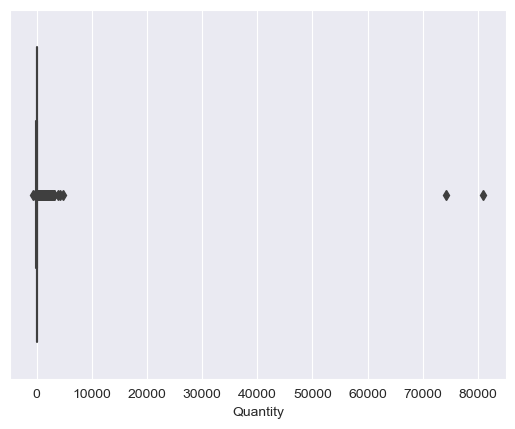

count    397769.000000
mean         12.981474
std         179.362760
min        -720.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64 AxesSubplot(0.125,0.11;0.775x0.77) count    397769.000000
mean         12.993496
std         179.361889
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


C:\Users\dimas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


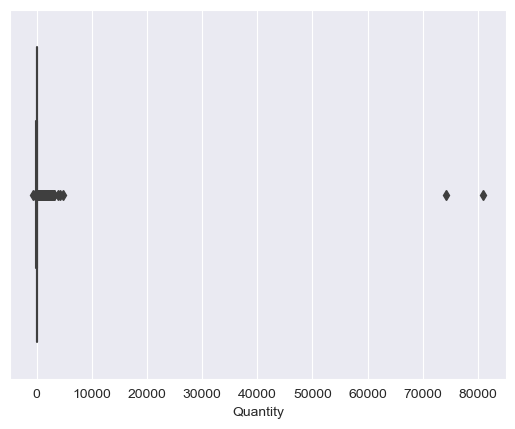

In [110]:
print(df['Quantity'].describe(),sns.boxplot(df['Quantity']),np.abs(df['Quantity']).describe())

I have noticed that outliers appear in orerds for manuals mostly so i will take a look at them

In [111]:
print(df.loc[df['Description']=="Manual",'UnitPrice'].describe(),len(df.loc[df['UnitPrice']>100,'UnitPrice']))

count     286.000000
mean      174.101573
std       583.589729
min         0.060000
25%         0.440000
50%         1.500000
75%        12.300000
max      4161.060000
Name: UnitPrice, dtype: float64 200
count     286.000000
mean      174.101573
std       583.589729
min         0.060000
25%         0.440000
50%         1.500000
75%        12.300000
max      4161.060000
Name: UnitPrice, dtype: float64 200


trimming the most obnoxious outliers

In [112]:
df = df[np.abs(df['Quantity'])<10000]
df = df[np.abs(df['UnitPrice'])<100]

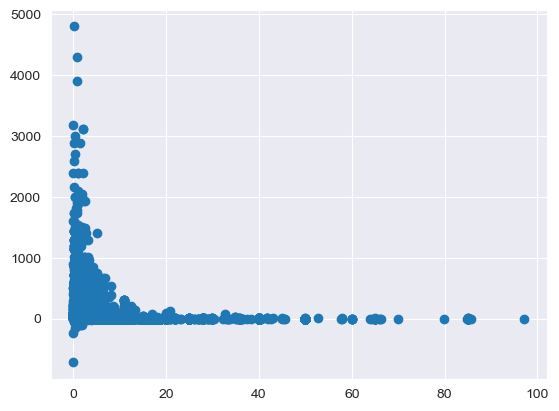

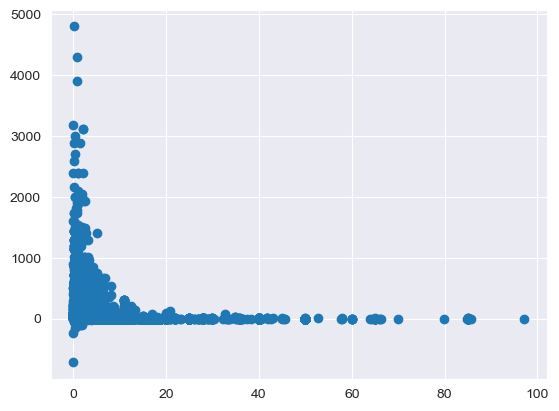

In [113]:
plt.scatter(df['UnitPrice'],df['Quantity'])

In [114]:
df.dtypes

InvoiceNo               category
StockCode               category
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID              category
Country                 category
order_canceled              bool
dtype: object

InvoiceNo               category
StockCode               category
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID              category
Country                 category
order_canceled              bool
dtype: object

an overall column for the order prices(if i decide to do pricing clustering may be useful)

In [115]:
df['OrderPrice'] = df['UnitPrice']*df['Quantity']

adding a column for overall money spent for each customer

In [116]:
df['BasketPrice'] = df.groupby('CustomerID')['OrderPrice'].transform('sum')

In [117]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,OrderPrice,BasketPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,OrderPrice,BasketPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21


split,then remove unneeded words,then tokenize the remaining ones

In [118]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['Description'] = df['Description'].apply(lambda x: " ".join([word for word in word_tokenize(x.lower()) if word not in stop_words]))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


vectorising everything.I have chosen tfid because count vectoriser is not that suited for clustering,and other vectoriser differ in the usage even further

In [119]:
vectorizer = TfidfVectorizer()
tfidf_scores = vectorizer.fit_transform(df['Description'])
keywords = set(vectorizer.get_feature_names_out())
categories = defaultdict(list)

making a column for words in description(may be used later)

In [120]:
df['Words'] = df['Description'].apply(word_tokenize)
df['Words'] = df['Words'].apply(set)

creating actual categories

In [121]:
def categorize(row):
    words = row['Words']
    for word in keywords & words:
        categories[word].append(row['Description'])

In [122]:
df.apply(categorize, axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
541904    None
541905    None
541906    None
541907    None
541908    None
Length: 397567, dtype: object

0         None
1         None
2         None
3         None
4         None
          ... 
541904    None
541905    None
541906    None
541907    None
541908    None
Length: 397567, dtype: object

In [123]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,OrderPrice,BasketPrice,Words
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30,5391.21,"{t-light, white, heart, hanging, holder}"
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,"{white, metal, lantern}"
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00,5391.21,"{hearts, hanger, cupid, coat, cream}"
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,"{hot, knitted, water, union, flag, bottle}"
4,536365,84029E,red woolly hottie white heart .,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,"{white, red, woolly, heart, hottie, .}"


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,OrderPrice,BasketPrice,Words
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30,5391.21,"{t-light, white, heart, hanging, holder}"
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,"{white, metal, lantern}"
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00,5391.21,"{hearts, hanger, cupid, coat, cream}"
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,"{hot, knitted, water, union, flag, bottle}"
4,536365,84029E,red woolly hottie white heart .,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,"{white, red, woolly, heart, hottie, .}"


removing colors

In [124]:
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'black', 'white', 'grey','polkadot']
df['Description'] = df['Description'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in colors]))

removing punctuation

In [125]:
signs = string.punctuation
df['Description'] = df['Description'].apply(lambda x: ''.join([char for char in x if char not in signs]))

checking what is considered punctuation in that module

In [126]:
signs

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [127]:
df = df.drop('Words',axis=1)

In [128]:
df.dtypes

InvoiceNo               category
StockCode               category
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID              category
Country                 category
order_canceled              bool
OrderPrice               float64
BasketPrice              float64
dtype: object

InvoiceNo               category
StockCode               category
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID              category
Country                 category
order_canceled              bool
OrderPrice               float64
BasketPrice              float64
dtype: object

trying to figure out optimal cluster number using elbow method(neither it nor silhouette score worked well but t shows at least some pattern,and IS computable unlike silhouette-score

In [129]:
word_counts = df['Description'].str.split().apply(pd.Series).stack().value_counts()

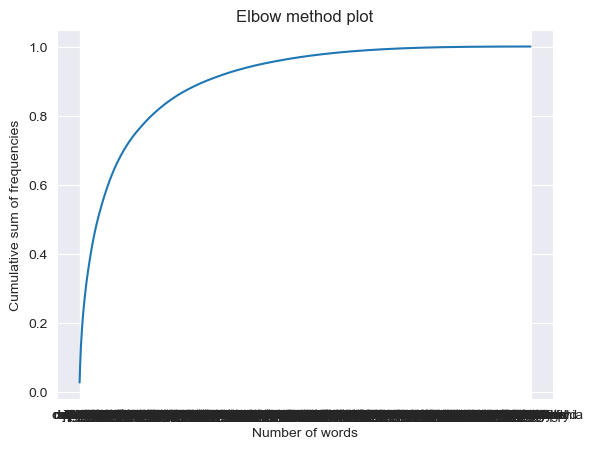

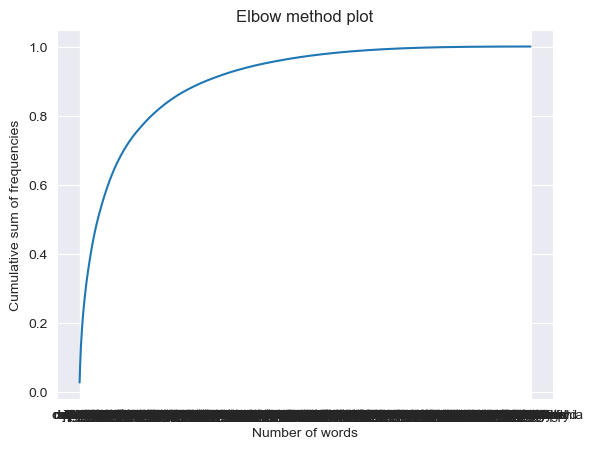

In [130]:
cumulative_sum = np.cumsum(word_counts / word_counts.sum())
plt.plot(cumulative_sum)
plt.xlabel('Number of words')
plt.ylabel('Cumulative sum of frequencies')
plt.title('Elbow method plot')
plt.show()

In [131]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,OrderPrice,BasketPrice
0,536365,85123A,hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30,5391.21
1,536365,71053,metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00,5391.21
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
4,536365,84029E,woolly hottie heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,OrderPrice,BasketPrice
0,536365,85123A,hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30,5391.21
1,536365,71053,metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00,5391.21
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21
4,536365,84029E,woolly hottie heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21


again using vectoriser for the prepared column

In [132]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Description'])

using kmeans for clustering(minibatchers or paralel processing were not needed due to the small size of dataset)

In [52]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(n_clusters=5)

In [53]:
df['ProductCluster'] = kmeans.labels_
df['ProductCluster'] = df['ProductCluster'].astype('category')

In [54]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,OrderPrice,BasketPrice,ProductCluster
0,536365,85123A,hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30,5391.21,3
1,536365,71053,metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,0
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00,5391.21,0
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,0
4,536365,84029E,woolly hottie heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34,5391.21,3


In [55]:
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek

now i copy unchanged dataset to prepare it for customer segmentation

In [56]:
df_advert = df.copy(deep=True)

In [57]:
col_to_drop =['InvoiceNo','Description','order_canceled','StockCode']

In [58]:
df_advert = df_advert.drop(col_to_drop,axis=1)

In [59]:
print(df_advert.head(),df_advert.dtypes)

   Quantity         InvoiceDate  UnitPrice CustomerID         Country  \
0         6 2010-12-01 08:26:00       2.55    17850.0  United Kingdom   
1         6 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   
2         8 2010-12-01 08:26:00       2.75    17850.0  United Kingdom   
3         6 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   
4         6 2010-12-01 08:26:00       3.39    17850.0  United Kingdom   

   OrderPrice  BasketPrice ProductCluster  InvoiceDayOfWeek  
0       15.30      5391.21              3                 2  
1       20.34      5391.21              0                 2  
2       22.00      5391.21              0                 2  
3       20.34      5391.21              0                 2  
4       20.34      5391.21              3                 2   Quantity                     int64
InvoiceDate         datetime64[ns]
UnitPrice                  float64
CustomerID                category
Country                   category
OrderPrice    

prepare columns for pricing groups

In [60]:
df_advert['MeanOrdPrice'] = df_advert.groupby('CustomerID')['OrderPrice'].transform('mean')
df_advert['MeanUnitPrice'] = df_advert.groupby('CustomerID')['UnitPrice'].transform('mean')
df_advert['StdOrdPrice'] = df_advert.groupby('CustomerID')['OrderPrice'].transform('std')
df_advert['StdUnitPrice'] = df_advert.groupby('CustomerID')['UnitPrice'].transform('std')

dropping unneeded columns because they might wreck results and WILL slow down computations

In [61]:
df_advert = df_advert.drop(['InvoiceDate','InvoiceDayOfWeek','Quantity','OrderPrice','UnitPrice'],axis=1)

splitting dataset into data for interests clustering and pricing clustering

In [62]:
df_advert_prod = df_advert[['ProductCluster','MeanUnitPrice','CustomerID']]
df_advert_price = df_advert.drop(['ProductCluster','Country'],axis=1)

Now I will be doing only clustering based on interests(pricing data is actually prepared "just in case"

In [63]:
df_advert_prod.head(15)

,ProductCluster,MeanUnitPrice,CustomerID
0,3,3.960370,17850.0
1,0,3.960370,17850.0
2,0,3.960370,17850.0
3,0,3.960370,17850.0
4,3,3.960370,17850.0
5,2,3.960370,17850.0
6,3,3.960370,17850.0
7,0,3.960370,17850.0
8,0,3.960370,17850.0
9,0,3.932035,13047.0


In [64]:
df_advert_prod.dtypes

ProductCluster    category
MeanUnitPrice      float64
CustomerID        category
dtype: object

one-hot encoding products in orders and grouping by customer(i have anticipated this in the beginning,nd that is actually the reason for dropping rows with missing customer id's)

In [65]:
df_advert_prod = pd.get_dummies(df_advert_prod, columns=['ProductCluster'])
grouped_df = df_advert_prod.groupby('CustomerID').sum()
df_advert_prod = grouped_df.reset_index()

dropping duplicated data(now i have managed to get all the data about a single customer which interests me in this ase in one row)

In [66]:
df_advert_prod=df_advert_prod.drop_duplicates()

In [67]:
df_advert_prod.head()

,CustomerID,MeanUnitPrice,ProductCluster_0,ProductCluster_1,ProductCluster_2,ProductCluster_3,ProductCluster_4
0,12346.0,0.00,0.0,0.0,0.0,0.0,0.0
1,12347.0,481.21,117.0,26.0,22.0,12.0,5.0
2,12348.0,178.71,11.0,2.0,18.0,0.0,0.0
3,12349.0,305.10,42.0,7.0,14.0,9.0,0.0
4,12350.0,65.30,15.0,1.0,0.0,0.0,1.0


and now dropping id's,they were needed only for preprocessing

In [68]:
df_advert_prod=df_advert_prod.drop('CustomerID',axis=1)

In [69]:
df_advert_prod.shape

(4372, 6)

i have actually left it here because custering turned out to be better with

C:\Users\dimas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MeanUnitPrice'>

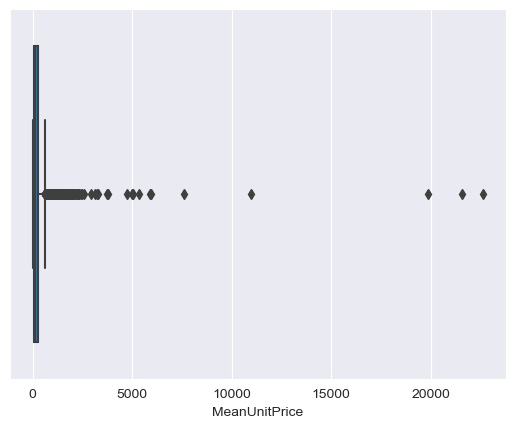

In [70]:
sns.boxplot(df_advert_prod['MeanUnitPrice'])

In [71]:
df_advert_prod = df_advert_prod[df_advert_prod['MeanUnitPrice']<1000]

C:\Users\dimas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MeanUnitPrice'>

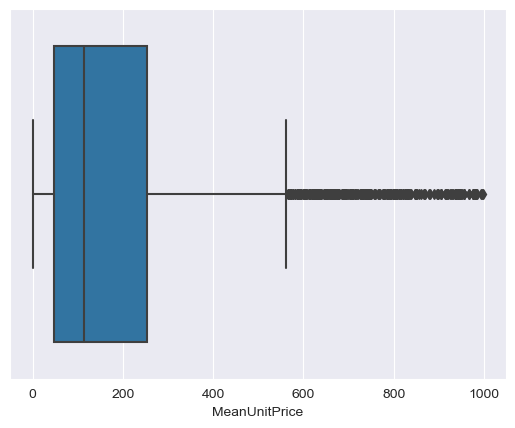

In [72]:
sns.boxplot(df_advert_prod['MeanUnitPrice'])

In [73]:
df_advert_prod.describe()

,MeanUnitPrice,ProductCluster_0,ProductCluster_1,ProductCluster_2,ProductCluster_3,ProductCluster_4
count,4196.000000,4196.000000,4196.000000,4196.000000,4196.000000,4196.000000
mean,187.505465,39.372736,6.562917,8.939228,5.662059,5.198761
std,200.770568,45.965881,8.961371,12.325420,9.158761,14.115615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.015000,9.000000,1.000000,1.000000,0.000000,0.000000
50%,113.995000,22.000000,3.000000,5.000000,2.000000,0.000000
75%,253.875000,53.000000,9.000000,12.000000,7.000000,4.000000
max,998.540000,356.000000,103.000000,113.000000,95.000000,189.000000


scaling(i have actually tried multiple scalers just to check,but as expected,abs scaler show the best performance on a data with non-linearly related features which are not normally distributed)

In [74]:
scaler_abs = MaxAbsScaler()
df_advert_prod_scaled_abs= scaler_abs.fit_transform(df_advert_prod)

In [75]:
n_clusters = 4
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30,max_iter=100)
kmeans.fit(df_advert_prod_scaled_abs)
clusters_clients = kmeans.predict(df_advert_prod_scaled_abs)
silhouette_avg = silhouette_score(df_advert_prod_scaled_abs, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.407


checking sizes of clusters(I was afraid of ubnormally small ones)

In [76]:
cluster_sizes = np.bincount(clusters_clients)
print("Cluster sizes:", cluster_sizes)

Cluster sizes: [1094  532 2317  253]


training/testing random forest for classifying data into one of the clusters

In [77]:
labels = kmeans.labels_
X_train, X_test, y_train, y_test = train_test_split(df_advert_prod_scaled_abs, labels, test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

visualizing learning curves for the forest

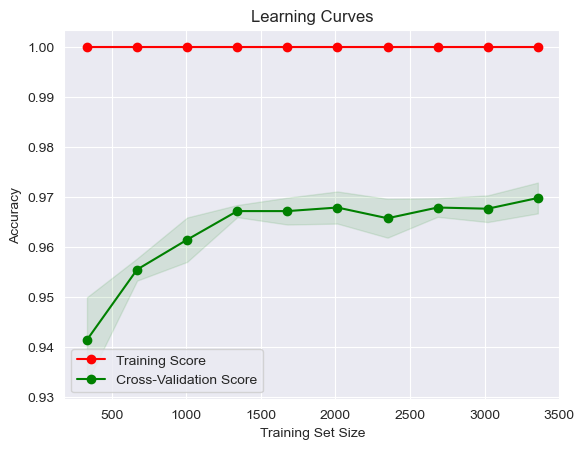

In [78]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(clf, df_advert_prod_scaled_abs, labels, cv=5, n_jobs=-1,
                                                        train_sizes=train_sizes, scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

now trying KNN(spoiler-I have also tried some other models just to check,but their oerformance was even worse for obvious reasons)

C:\Users\dimas\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\dimas\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

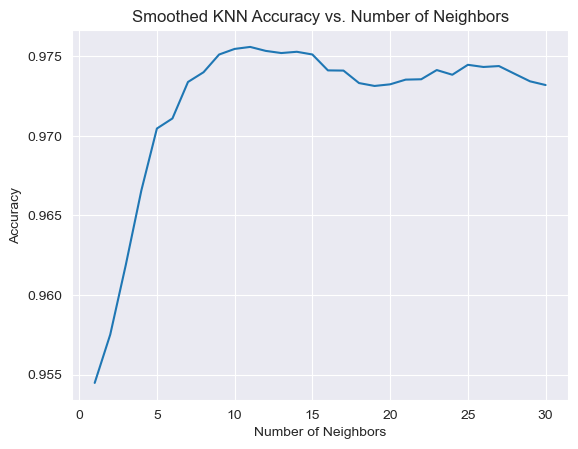

In [79]:
k_range = range(1, 31)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, df_advert_prod_scaled_abs, labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
window_length = 7
polyorder = 3
smooth_cv_scores = savgol_filter(cv_scores, window_length, polyorder)
plt.plot(k_range, smooth_cv_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Smoothed KNN Accuracy vs. Number of Neighbors')
plt.show()

doing same visualization

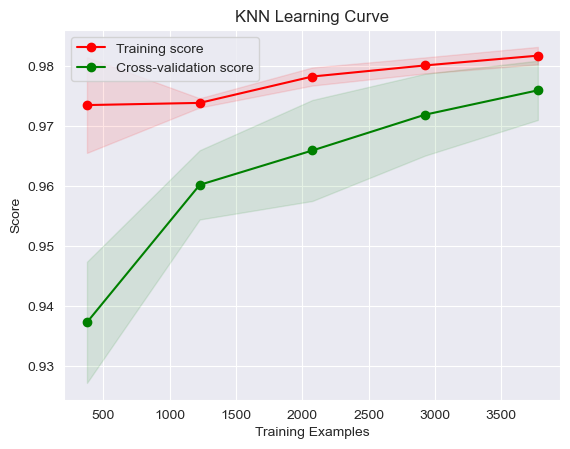

In [80]:
knn = KNeighborsClassifier(n_neighbors=10)
train_sizes, train_scores, test_scores = learning_curve(knn, df_advert_prod_scaled_abs, labels, cv=10, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.title("KNN Learning Curve")
plt.show()

actually setting the model so that it may be used further

In [81]:
dump(knn, 'knn_classifier.joblib')

['knn_classifier.joblib']